In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.utils.data.dataloader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets
import os
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Tuple,Dict,List
from torchinfo import summary
from tqdm.auto import tqdm
from timeit import default_timer as timer
import torchvision
import random
from pathlib import Path

C:\Users\Enes\Desktop\COMPUTER VİSİON\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
from goingmodular import data_setup
data_path=Path()
train_dir=data_path / "train"
test_dir=data_path / "test"


In [5]:
weights=torchvision.models.GoogLeNet_Weights.DEFAULT
auto_transforms=weights.transforms()

from goingmodular import data_setup
train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                          test_dir=test_dir,
                                                                          train_transforms=auto_transforms,
                                                                          test_transforms=auto_transforms,
                                                                          batch_size=32)

In [7]:
model=torchvision.models.googlenet(weights=weights)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\Enes/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100%|█████████████████████████████████████████████████████████████████████████████| 49.7M/49.7M [00:06<00:00, 7.95MB/s]


In [9]:
for param in model.parameters():
    param.requires_grad=False

In [10]:
summary(model=model,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GoogLeNet (GoogLeNet)                    [32, 3, 224, 224]    [32, 1000]           --                   False
├─BasicConv2d (conv1)                    [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    └─Conv2d (conv)                     [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (bn)                  [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─MaxPool2d (maxpool1)                   [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─BasicConv2d (conv2)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─Conv2d (conv)                     [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    └─BatchNorm2d (bn)                  [32, 64, 56, 56]     [32, 64, 56, 56]     (128)                False
├─BasicCo

In [13]:
model.fc = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, len(class_names)),
                                 nn.LogSoftmax(dim=1)).to(device)

In [14]:
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)


In [15]:
from goingmodular import engine
from timeit import default_timer as timer
start_time=timer()
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
results=engine.train(model=model.cuda(),
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=5,
                    device=device)
end_time=timer()
print(f"[INFO]Total training time= {end_time-start_time:.3f} seconds")

 20%|████████████████▌                                                                  | 1/5 [01:44<06:59, 104.86s/it]

Epoch:0| train_loss:0.4697|train_acc:0.8260|test_loss:0.3133|test_acc:0.8892


 40%|█████████████████████████████████▌                                                  | 2/5 [03:18<04:54, 98.28s/it]

Epoch:1| train_loss:0.3751|train_acc:0.8614|test_loss:0.2989|test_acc:0.8926


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [04:51<03:11, 95.71s/it]

Epoch:2| train_loss:0.3463|train_acc:0.8674|test_loss:0.2866|test_acc:0.8961


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [06:22<01:34, 94.09s/it]

Epoch:3| train_loss:0.3277|train_acc:0.8765|test_loss:0.3009|test_acc:0.8932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:59<00:00, 95.90s/it]

Epoch:4| train_loss:0.3308|train_acc:0.8761|test_loss:0.2854|test_acc:0.8907
[INFO]Total training time= 479.502 seconds


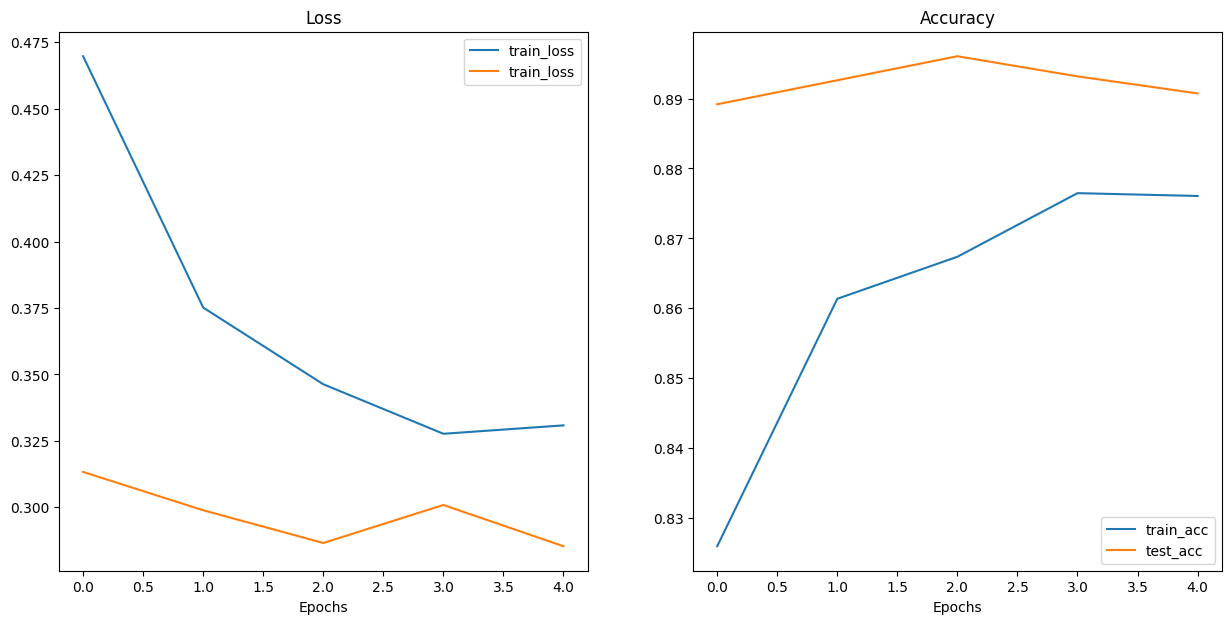

In [18]:
from goingmodular import utils

utils.plot_loss_curves(results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


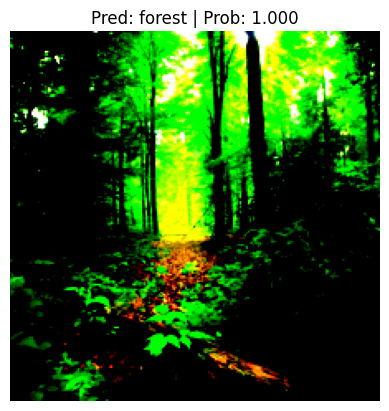

In [19]:
from goingmodular import single_pred

single_pred.pred_and_plot_image(model=model,
                                image_path="forest.jpg",
                                class_names=class_names,
                                transform=auto_transforms,
                                device=device)